# CB Refactoring

In [1]:
import numpy as np

from climada.util.api_client import Client
from climada.entity import ImpactFunc

from climada.entity import LitPop

import copy
client = Client()


## Parameters

In [2]:
# Parameters
ctr_str = 'DEU'

# Years to be considered
years = [2000, 2020, 2050]

# Create the snapshots - Exposure, Hazard sets, Impact Functions

### Exposure

In [3]:
exp_hist = LitPop().from_countries(countries=ctr_str, reference_year=years[0])

# Assign random Group_id of 3 possible to the gdf
reg_id_arr = np.random.randint(0, 3, exp_hist.gdf.shape[0])
exp_hist.gdf['region_id'] = reg_id_arr

# Present
exp_pres = LitPop().from_countries(countries=ctr_str, reference_year=years[1])
# Assign the region_ids
exp_pres.gdf['region_id'] = reg_id_arr

# Future
exp_fut =copy.deepcopy(exp_pres)
# Exponential growth
exp_growth_rate = 0.01
exp_fut.gdf.value = exp_fut.gdf.value * (1 + exp_growth_rate)**(years[2] - years[1])
# Assign the region_ids
exp_fut.gdf['region_id'] = reg_id_arr

## Hazard sets

In [4]:
haz_fl_1980 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'historical',
        'year_range': '1980_2000',
        'country_iso3alpha': 'DEU'
    })

haz_fl_2010 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'rcp85',
        'year_range': '2010_2030',
        'country_iso3alpha': 'DEU'
    })

haz_fl_2030 = client.get_hazard(
    hazard_type='river_flood',
    properties={
        'climate_scenario' : 'rcp85',
        'year_range': '2030_2050',
        'country_iso3alpha': 'DEU'
    })

### Impact Functions

array([<Axes: title={'center': 'RF 1: Flood Africa JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>,
       <Axes: title={'center': 'RF 2: Flood Asia JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>],
      dtype=object)

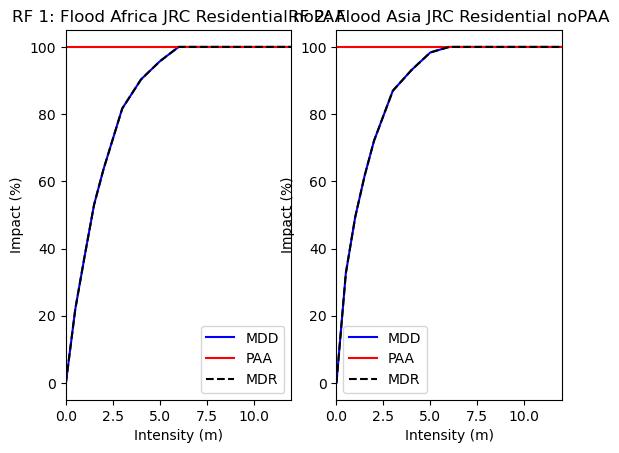

In [210]:
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood, flood_imp_func_set
from climada.entity import ImpactFunc, ImpactFuncSet

impf_set_flood = flood_imp_func_set()

impf_1 = impf_set_flood.get_func(fun_id=1, haz_type='RF')
impf_2 = impf_set_flood.get_func(fun_id=2, haz_type='RF')
impfset = ImpactFuncSet([impf_1, impf_2])


impfset.plot()

### Assign Impact Functions ID

In [6]:
def assign_impfid(exp_hist, exp_pres, exp_fut, case='single'):
    if case=='single':
        exp_hist.gdf['impf_RF'] = 1
        exp_pres.gdf['impf_RF'] = 1
        exp_fut.gdf['impf_RF'] = 1
    if case=='multiple_spatial':
        exp_hist.gdf.loc[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_pres.gdf[:len(exp_pres.gdf/2),'impf_RF'] = 1
        exp_fut.gdf[:len(exp_fut.gdf/2),'impf_RF'] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf/2):,'impf_RF'] = 2
        exp_pres.gdf[len(exp_pres.gdf/2):,'impf_RF'] = 2
        exp_fut.gdf[len(exp_fut.gdf/2):,'impf_RF'] = 2
    if case=='multiple_temp':
        exp_hist.gdf['impf_RF'] = 1
        exp_pres.gdf['impf_RF'] = 1
        exp_fut.gdf['impf_RF'] = 2
    if case == ' multiple':
        exp_hist.gdf.loc[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_pres.gdf[:len(exp_hist.gdf/2),'impf_RF'] = 2
        exp_fut.gdf[:len(exp_hist.gdf/2),'impf_RF'] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf/2):,'impf_RF'] = 2
        exp_pres.gdf[len(exp_hist.gdf/2):,'impf_RF'] = 1
        exp_fut.gdf[len(exp_hist.gdf/2):,'impf_RF'] = 2

### Create the Snapshots

In [141]:
from climada.engine.impact_trajectories import Snapshot, SnapshotsCollection

hazard_list = [haz_fl_1980, haz_fl_2010, haz_fl_2030]
exposure_list = [exp_hist, exp_pres, exp_fut]
snapshot_years = years

snapshots = SnapshotsCollection.from_lists( hazard_list, exposure_list, impfset, snapshot_years)

# Create an arr
snap_years_range = np.array(range(snapshots.snapshots_years[0], snapshots.snapshots_years[-1]+1))


### Define the measures

In [220]:
# Define the measure
from climada.entity.measures.base import Measure, helper_hazard, helper_impfset, helper_exposure

# Add to measure set list
meas_list = []

# Measure
haz_func = helper_hazard(0.8, 0)
exp_func = helper_exposure(reassign_impf_id=1, haz_type='RF')
impfset_func = helper_impfset(haz_type='RF')
meas1 = Measure(
    name='test1', start_year=2018, end_year=2020,
    exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func
    )
meas_list.append(meas1)

# # Measure
# haz_func = helper_hazard(1.7, -1)
# exp_func = helper_exposure(reassign_impf_id=2, haz_type='RF')
# impfset_func = helper_impfset(haz_type='RF', impf_mdd_modifier={2: (0.6, 0)})

# meas2 = Measure(
#     name='test2', start_year=2021, end_year=2049,
#     exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func
#     )
# meas_list.append(meas2)

# # Measure
# haz_func = helper_hazard(0.6, -1)
# exp_func = helper_exposure(reassign_impf_id=2, haz_type='RF')
# impfset_func = helper_impfset(haz_type='RF', impf_mdd_modifier={2: (0.8, 0)})
# meas3 = Measure(
#     name='test3', start_year=2001, end_year=2018,
#     exposures_change=exp_func, impfset_change=impfset_func, hazard_change=haz_func
#     )
# meas_list.append(meas3)


### Add to the Measure Set

In [221]:
from climada.entity.measures import MeasureSet

# meas_set = MeasureSet([meas1])



# Calc the aai for each year

## No measure case

### Create a Risk Metrics Container

In [222]:
import pandas as pd

columns = ['year', 'measure', 'aai']
base_rm_df = pd.DataFrame(columns=columns)

# Create a dictionary container for the no climate change scenario, no growth scenario, and the combined scenario
rm_dict = {}
rm_dict['both'] = base_rm_df

In [223]:
from climada.engine.impact_trajectories import CalcImpactsSnapshots

# Populate the base_rm_df with the aai for the no measure case
temp_rm_df = base_rm_df.copy()

# Get the aai for the snapshots
temp_rm_df['aai'] = CalcImpactsSnapshots(snapshots).calc_all_years()
temp_rm_df['measure'] = 'no_measure'
temp_rm_df['year'] = snap_years_range

# Add temp_rm_df to the rm_dict check if empty
if rm_dict['both'].empty:
    rm_dict['both'] = temp_rm_df
else:
    rm_dict['both'] = pd.concat([rm_dict['both'], temp_rm_df])


## Measure case

In [224]:
# Create a new snapshot collection based on the measure

for meas in meas_list:

    # Get the start and end year of the measure
    start_year = meas.start_year
    end_year = meas.end_year

    # Change the exposure, hazard and impfset for the affected snapshot years
    hazard_list = []
    exposure_list = []
    snapshot_years = []

    for snap in snapshots.data:
        # Apply the measure on all the snapshots
        exp_new, impfset_new, haz_new = meas.apply(snap.exposure, snap.impfset, snap.hazard)

        # Append the new exposure, hazar, impfset and snapshot year
        hazard_list.append(haz_new)
        exposure_list.append(exp_new)
        impfset = impfset_new # The impfset is the same for all the snapshots
        snapshot_years.append(snap.year)

    # Create a new snapshot collection
    snapshots_meas = SnapshotsCollection.from_lists( hazard_list, exposure_list, impfset, snapshot_years)
        
    # Calculate the impacts
    snap_years = np.array(range(snapshots.snapshots_years[0], snapshots.snapshots_years[-1]+1))
    aai_meas = CalcImpactsSnapshots(snapshots_meas).calc_all_years()

    # Populate the base_rm_df with the aai for the no measure case
    temp_rm_df = base_rm_df.copy()
    temp_rm_df['year'] = snap_years  
    temp_rm_df['aai'] = aai_meas
    temp_rm_df['measure'] = meas.name

    # Get the aai for the snapshots
    aai_no_measure = rm_dict['both'][rm_dict['both']['measure']=='no_measure']['aai'].values

    # For the snap_years that the measure is not applied, the aai should be teh no 
    for year in snap_years:
        if year >= start_year and year <= end_year:
            pass
        else:
            temp_rm_df.loc[temp_rm_df['year']==year, 'aai'] = aai_no_measure[snap_years==year]

    # Add temp_rm_df to the rm_dict check if empty
    if rm_dict['both'].empty:
        rm_dict['both'] = temp_rm_df
    else:
        rm_dict['both'] = pd.concat([rm_dict['both'], temp_rm_df])




In [225]:
aai_meas

array([1.76026586e+10, 2.12627913e+10, 2.49762467e+10, 2.87430248e+10,
       3.25631258e+10, 3.64365494e+10, 4.03632959e+10, 4.43433651e+10,
       4.83767571e+10, 5.24634719e+10, 5.66035094e+10, 6.07968697e+10,
       6.50435527e+10, 6.93435585e+10, 7.36968871e+10, 7.81035385e+10,
       8.25635126e+10, 8.70768094e+10, 9.16434291e+10, 9.62633715e+10,
       1.00936637e+11, 1.02139323e+11, 1.03342750e+11, 1.04546919e+11,
       1.05751828e+11, 1.06957479e+11, 1.08163871e+11, 1.09371004e+11,
       1.10578878e+11, 1.11787493e+11, 1.12996850e+11, 1.14206947e+11,
       1.15417786e+11, 1.16629366e+11, 1.17841687e+11, 1.19054749e+11,
       1.20268552e+11, 1.21483096e+11, 1.22698382e+11, 1.23914408e+11,
       1.25131176e+11, 1.26348684e+11, 1.27566934e+11, 1.28785925e+11,
       1.30005658e+11, 1.31226131e+11, 1.32447345e+11, 1.33669301e+11,
       1.34891998e+11, 1.36115435e+11, 1.37339614e+11])

In [226]:
aai_no_measure

array([1.83185105e+10, 2.20974700e+10, 2.59315924e+10, 2.98208774e+10,
       3.37653253e+10, 3.77649359e+10, 4.18197093e+10, 4.59296455e+10,
       5.00947445e+10, 5.43150062e+10, 5.85904307e+10, 6.29210180e+10,
       6.73067680e+10, 7.17476809e+10, 7.62437565e+10, 8.07949948e+10,
       8.54013960e+10, 9.00629599e+10, 9.47796866e+10, 9.95515761e+10,
       1.04378628e+11, 1.05600239e+11, 1.06822110e+11, 1.08044241e+11,
       1.09266632e+11, 1.10489283e+11, 1.11712194e+11, 1.12935366e+11,
       1.14158797e+11, 1.15382488e+11, 1.16606440e+11, 1.17830651e+11,
       1.19055122e+11, 1.20279854e+11, 1.21504846e+11, 1.22730097e+11,
       1.23955609e+11, 1.25181381e+11, 1.26407413e+11, 1.27633705e+11,
       1.28860257e+11, 1.30087069e+11, 1.31314141e+11, 1.32541473e+11,
       1.33769065e+11, 1.34996918e+11, 1.36225030e+11, 1.37453402e+11,
       1.38682035e+11, 1.39910928e+11, 1.41140080e+11])

### Plot the aai per year

/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

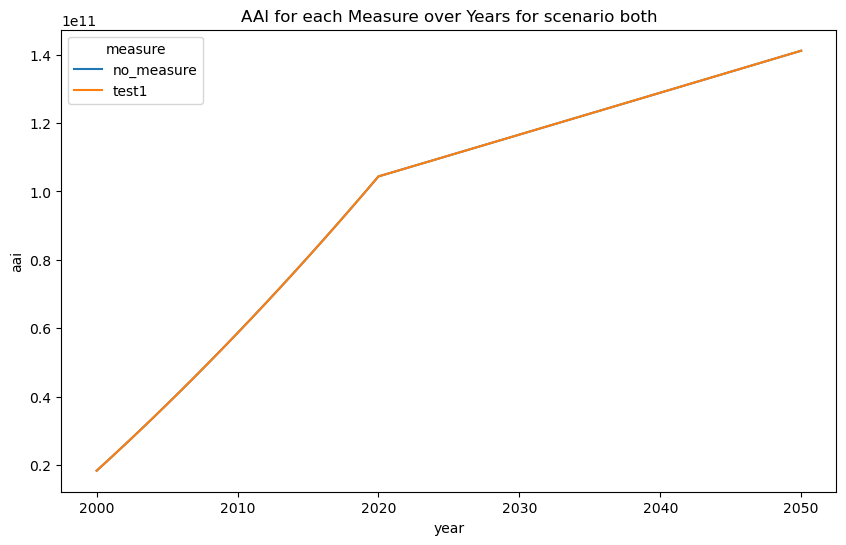

In [219]:
# Plot the results for 
import seaborn as sns
import matplotlib.pyplot as plt


for key in rm_dict.keys():
    temp_rm_df = rm_dict[key]
    # Plot the results for each measure
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=temp_rm_df, x='year', y='aai', hue='measure')
    plt.title(f'AAI for each Measure over Years for scenario {key}')
    plt.show()



In [51]:
# Make a wrapper for the measure


meas1.start_year
meas1.end_year

snapshots

# Get the snapshot years that the measure is within
snap_years_list = snapshots.snapshots_years

# Get the closest snapshot year to meas1.start_year that is equal or smaller than it 
snap_start = max(filter(lambda x: x <= meas1.start_year, snap_years_list), default=-1e10)
# Get the closest snapshot year to meas1.end_year that is equal or larger than it
snap_end = min(filter(lambda x: x >= meas1.end_year, snap_years_list), default=1e10)

# Get the start and end and the intermediate snapshot years
aff_snap_years = list(filter(lambda x: snap_start <= x <= snap_end, snap_years_list))

# Get the non-affected snapshot years
non_aff_snap_years = [snap_year for snap_year in snap_years_list if snap_year not in aff_snap_years]



2000 Snapshot(exposure=<climada.entity.exposures.litpop.litpop.LitPop object at 0x1bdaa2910>, hazard=<climada.hazard.base.Hazard object at 0x1bdd12fa0>, impfset=<climada.entity.impact_funcs.impact_func_set.ImpactFuncSet object at 0x1be3809a0>, year=2000)
2020 Snapshot(exposure=<climada.entity.exposures.litpop.litpop.LitPop object at 0x1ba4fd0d0>, hazard=<climada.hazard.base.Hazard object at 0x1c1247d00>, impfset=<climada.entity.impact_funcs.impact_func_set.ImpactFuncSet object at 0x1be3809a0>, year=2020)
2050 Snapshot(exposure=<climada.entity.exposures.litpop.litpop.LitPop object at 0x1bda83d30>, hazard=<climada.hazard.base.Hazard object at 0x1ba4ef190>, impfset=<climada.entity.impact_funcs.impact_func_set.ImpactFuncSet object at 0x1be3809a0>, year=2050)


Text(0.5, 1.0, 'Difference in AAI with and without the measure')

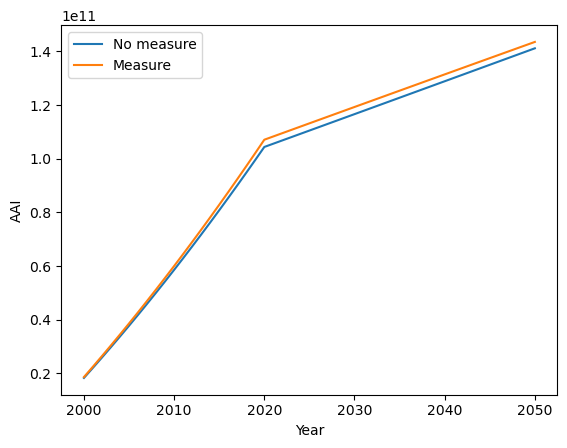

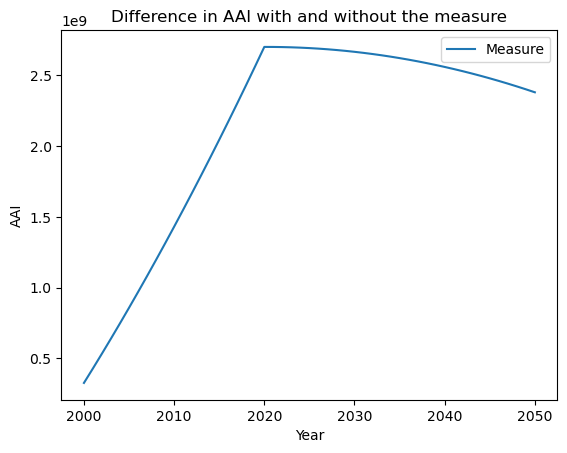

In [59]:
# Plot the AAI
plt.plot(snap_years, aai, label='No measure')
plt.plot(snap_years, calc_imp_snap, label='Measure')
plt.xlabel('Year')
plt.ylabel('AAI')
plt.legend()

# Plot the difference in a separate plot
plt.figure()
plt.plot(snap_years, calc_imp_snap - aai, label='Measure')
plt.xlabel('Year')
plt.ylabel('AAI')
plt.legend()
plt.title('Difference in AAI with and without the measure')
